In [1]:
!pip install opencv-python


In [2]:
# Schritt 1: Bibliotheken 
import os                           
import cv2                         
import pandas as pd                
import matplotlib.pyplot as plt    
from collections import defaultdict  # Für einfache Zählungen

# für schöne Diagramme
%matplotlib inline
plt.style.use("seaborn-v0_8")

In [3]:
#  Pfad zum Datenordner
basis_pfad = r"C:\Users\firas\Documents\Semester 4\Grundlagen der Computer Vision\archive (1)"

# Funktion: Zählt alle Bilder pro Emotion im gegebenen Ordner
def bildeanzahl_pro_emotion(ordner_pfad):
    zaehlungen = defaultdict(int)
    for emotion in os.listdir(ordner_pfad):
        emotions_pfad = os.path.join(ordner_pfad, emotion)
        if os.path.isdir(emotions_pfad):
            zaehlungen[emotion] = len(os.listdir(emotions_pfad))
    return dict(zaehlungen)

#  Bildanzahl für Trainings- und Testdaten ermitteln
train_counts = bildeanzahl_pro_emotion(os.path.join(basis_pfad, "train"))
test_counts = bildeanzahl_pro_emotion(os.path.join(basis_pfad, "test"))

#  Ausgabe
print(" Anzahl der Bilder im Trainingssatz:")
print(train_counts)

print("\nAnzahl der Bilder im Testsatz:")
print(test_counts)



 Anzahl der Bilder im Trainingssatz:
{'angry': 3995, 'disgusted': 436, 'fearful': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprised': 3171}

Anzahl der Bilder im Testsatz:
{'angry': 958, 'disgusted': 111, 'fearful': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprised': 831}


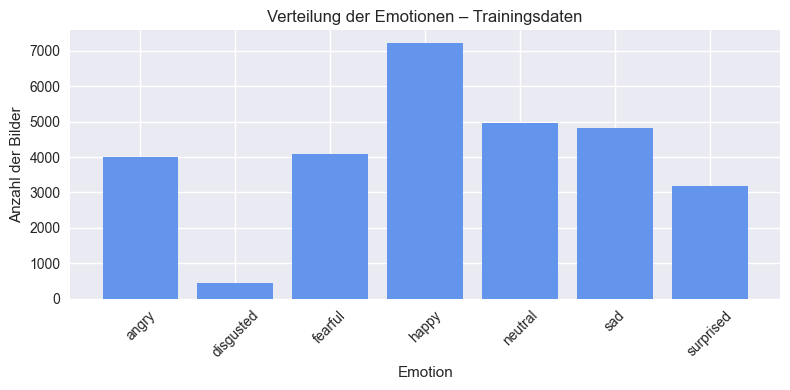

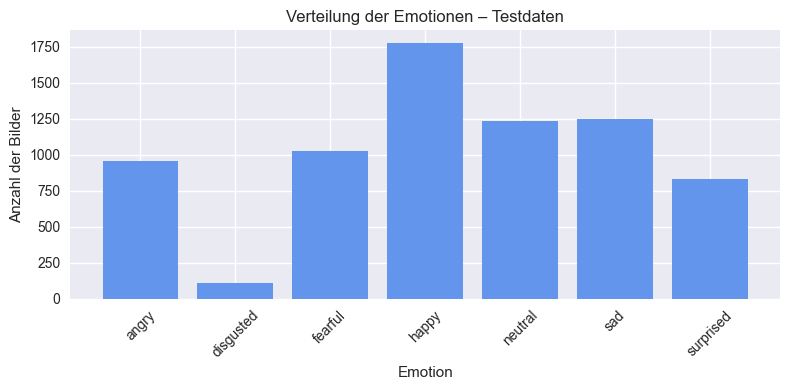

In [4]:
# Funktion: Erstellt ein Balkendiagramm der Emotionen
def plot_emotionen(daten, titel):
    plt.figure(figsize=(8, 4))
    plt.bar(daten.keys(), daten.values(), color="cornflowerblue")
    plt.title(titel)
    plt.xlabel("Emotion")
    plt.ylabel("Anzahl der Bilder")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Trainings- und Testdaten anzeigen
plot_emotionen(train_counts, "Verteilung der Emotionen – Trainingsdaten")
plot_emotionen(test_counts, "Verteilung der Emotionen – Testdaten")


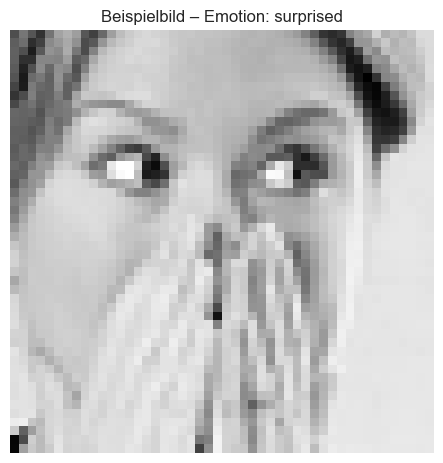

 Bildauflösung: (48, 48)


In [5]:
# Beispielbild auswählen
bildpfad = os.path.join(basis_pfad, "train", "surprised", "im99.png")

# Bild in Graustufen einlesen
bild = cv2.imread(bildpfad, cv2.IMREAD_GRAYSCALE)

# Bild anzeigen
plt.imshow(bild, cmap="gray")
plt.title("Beispielbild – Emotion: surprised")
plt.axis("off")
plt.show()

# Bildgröße anzeigen
print(f" Bildauflösung: {bild.shape}")


In [6]:
# Funktion: Gibt Häufigkeit der Bildgrößen zurück
def bildegroessen_analysieren(ordner_pfad):
    formen = []
    for emotion in os.listdir(ordner_pfad):
        emotions_pfad = os.path.join(ordner_pfad, emotion)
        for datei in os.listdir(emotions_pfad):
            bildpfad = os.path.join(emotions_pfad, datei)
            bild = cv2.imread(bildpfad, cv2.IMREAD_GRAYSCALE)
            if bild is not None:
                formen.append(bild.shape)
    return pd.Series(formen).value_counts()

# Analyse der Trainingsdaten
print(" Häufigkeit der Bildgrößen im Trainingsdatensatz:")
bildegroessen_analysieren(os.path.join(basis_pfad, "train"))


 Häufigkeit der Bildgrößen im Trainingsdatensatz:


(48, 48)    28709
Name: count, dtype: int64

In [7]:
import numpy as np

# Emotionen-Ordner (z. B. train/wütend, train/glücklich, ...)
emotion_labels = os.listdir(os.path.join(basis_pfad, "train"))
label_mapping = {emotion: idx for idx, emotion in enumerate(emotion_labels)}  # z. B. {'angry': 0, 'happy': 1, ...}

def lade_bilder_und_labels(basisordner):
    bilder = []
    labels = []
    for emotion in emotion_labels:
        ordner = os.path.join(basisordner, emotion)
        for dateiname in os.listdir(ordner):
            pfad = os.path.join(ordner, dateiname)
            bild = cv2.imread(pfad, cv2.IMREAD_GRAYSCALE)
            if bild is not None:
                bild = cv2.resize(bild, (48, 48))  # falls nicht 48x48
                bilder.append(bild)
                labels.append(label_mapping[emotion])
    return np.array(bilder), np.array(labels)

# Lade Trainings- und Testdaten
X_train_bilder, y_train = lade_bilder_und_labels(os.path.join(basis_pfad, "train"))
X_test_bilder, y_test = lade_bilder_und_labels(os.path.join(basis_pfad, "test"))


In [8]:
!pip install scikit-image


In [9]:
from skimage.feature import hog

def berechne_hog_features(bild_array):
    hog_features = []
    for bild in bild_array:
        feature = hog(bild,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      block_norm='L2-Hys',
                      visualize=False)
        hog_features.append(feature)
    return np.array(hog_features)

# Extrahiere HOG-Features
X_train_hog = berechne_hog_features(X_train_bilder)
X_test_hog = berechne_hog_features(X_test_bilder)


In [10]:
from sklearn.utils import shuffle

# Anzahl gewünschter Trainingsbilder
anzahl = 10000

# Vermische Daten zufällig (wichtig)
X_train_hog, y_train = shuffle(X_train_hog, y_train, random_state=42)

# Nur die ersten n verwenden
X_train_hog_subset = X_train_hog[:anzahl]
y_train_subset = y_train[:anzahl]

# Modell trainieren
from sklearn.svm import SVC

model = SVC(kernel='linear', probability=True)
model.fit(X_train_hog_subset, y_train_subset)


SVC(kernel='linear', probability=True)

Accuracy: 0.4205906937865701

Klassifikationsbericht:

              precision    recall  f1-score   support

       angry       0.29      0.30      0.30       958
   disgusted       0.37      0.18      0.24       111
     fearful       0.29      0.24      0.26      1024
       happy       0.55      0.70      0.61      1774
     neutral       0.40      0.41      0.40      1233
         sad       0.30      0.27      0.28      1247
   surprised       0.60      0.46      0.52       831

    accuracy                           0.42      7178
   macro avg       0.40      0.37      0.38      7178
weighted avg       0.41      0.42      0.41      7178



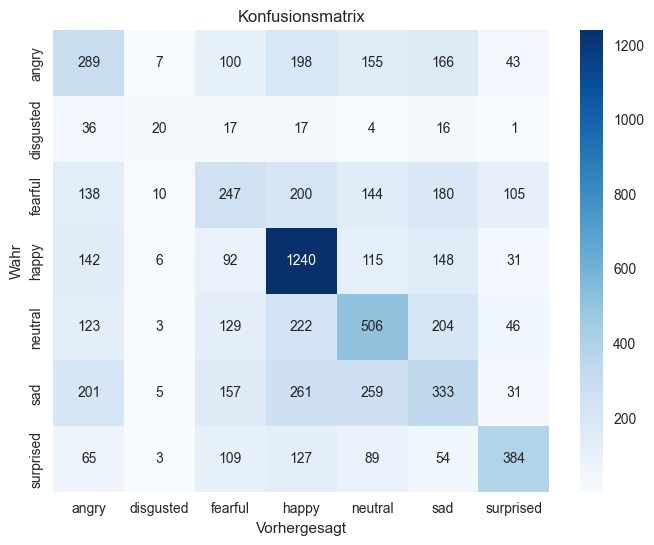

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_hog)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nKlassifikationsbericht:\n")
print(classification_report(y_test, y_pred, target_names=emotion_labels))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, xticklabels=emotion_labels, yticklabels=emotion_labels, fmt='d', cmap='Blues')
plt.xlabel("Vorhergesagt")
plt.ylabel("Wahr")
plt.title("Konfusionsmatrix")
plt.show()
